<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Examinar el efecto de cuántos puntos y cuáles puntos usar en la calidad del resultado final

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import statsmodels.tools.eval_measures as bias
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg

In [84]:
df    = pd.read_csv('minitest.csv')
df    = pd.read_csv('demanda.csv')
#dfw   = pd.read_csv('pesos1.csv')
#W     = np.asarray(pd.DataFrame(dfw[['1','2','3','4','5','6','7','8','9']]).to_numpy())
X     = pd.DataFrame(df[['X1','X2']]).to_numpy()
Y     = pd.DataFrame(df[['Y']]).to_numpy()

## Regresión local en $\mathcal{Rp}$

Damos mayor peso a las puntos $x_I\in\mathcal{Rp}$ mas cercanos al punto $x_o\in\mathcal{Rp}$ y menos peso a las observaciones más lejanas. 
Calcularemos los pesos de los puntos utilizando una función de peso que asigna importancia a cada uno de los k vecinos de x según su distancia a xo. Esta es la idea básica detrás de una estimación kernel: dar un peso diferente a las observaciones con una distancia diferente.

In [85]:
# Calcula los pesos. Regresa una matriz diagonal con los pesos
def get_weight(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    m = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(m)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento [x(i)'s].
    for i in range(m): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d) 
        
    return weight

W = get_weight(1,X,25)

Para cada uno de los datos, seleccionaremos una vecindad adecuada de puntos muestreados y los usaremos como conjunto de entrenamiento para un problema de regresión lineal. Aunque solo ajustamos un modelo lineal completo a los datos en la región, solo lo usamos para evaluar el ajuste en el único punto x0.

Calculamos el valor de los coeficientes beta de una regresión lineal usando:

image.png

In [86]:
def local_regression(X,W,Xo):
    # W     --> Matriz diagonal de pesos
    # X     --> Regresores
    # x0    --> the x where we want to make the prediction.
    Xt = X.T
    a = np.matmul(Xt, np.matmul(W,X)) 
    a = np.linalg.inv( a )
    b = np.matmul(Xt, np.matmul(W,Y)) 
    beta = np.matmul(a,b)
    #Xo = np.asarray([1,4,4,16,16])
    prediccion = np.matmul(Xo,beta)
    return prediccion, beta

In [87]:
Y_pred= []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = np.mat(np.eye(X.shape[0])) 
    Ygorro, beta = local_regression(X,W,xo)
    Y_pred.append(Ygorro.item(0))

In [88]:
Y_local = []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = get_weight(xo,X,25)
    Ygorro, beta = local_regression(X,W,xo)
    Y_local.append(Ygorro.item(0))

In [89]:
mae_pred  = mean_absolute_error(Y,Y_pred)
mae_local = mean_absolute_error(Y,Y_local)
print(mae_pred)
print(mae_local)

138.58610501023426
83.50683177354368


In [90]:
mse_pred  = mean_squared_error(Y,Y_pred)
mse_local = mean_squared_error(Y,Y_local)
print(mse_pred)
print(mse_local)

32615.195124735048
14118.722086598847


In [91]:
mape_pred  = mean_absolute_percentage_error(Y,Y_pred)
mape_local = mean_absolute_percentage_error(Y,Y_local)
print(mape_pred)
print(mape_local)

0.01598408809436051
0.009619220707356695


No handles with labels found to put in legend.


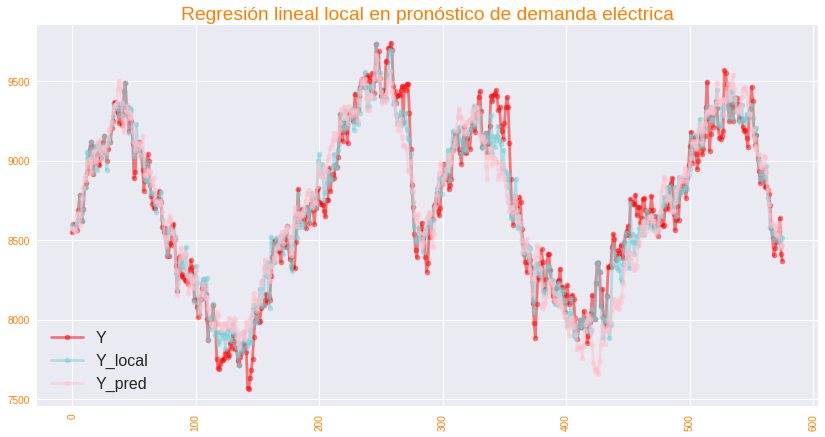

In [92]:
fig  = plt.figure(figsize=(14,7))
axes = fig.add_subplot(1, 1, 1)
plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VEDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(   colors=LETRASNARA, which='both')

axes.plot  ( Y      , '.-'  , color = 'red'  , label = 'Y'  ,alpha=1/2)
axes.plot  ( Y_local, '.-'  , color = CYAN   , label = 'Y_local'  ,alpha=1/2)
axes.plot  ( Y_pred , '.-'  , color = 'pink' , label = 'Y_pred'  ,alpha=1/2)
#axes.plot  ( xspline[3], yspline[3] , '.-'  , color = VEDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot  ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)

#plt.scatter( x, y,           s=170 ,  marker='o' , color = 'red'   , label = 'X'        ,alpha=1)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([-5,  150, 7400, 9800])
#plt.axis([150, 300, 7400, 9800])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda1.png', transparent=True)
plt.show()

**EJEMPLO EN UNA DIMENSIÓN**

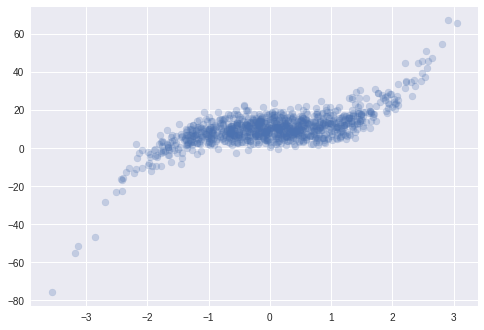

In [93]:
plt.style.use("seaborn")
np.random.seed(8)
X = np.random.randn(1000,1)
Y = 2*(X**3) + 10 + 4.6*np.random.randn(1000,1)
plt.scatter(X, Y, alpha=0.25)
plt.show()

In [94]:
# Weight Matrix in code. It is a diagonal matrix.
def weightmatrix(point, X, tau): 
    
  # tau   --> bandwidth
  # X     --> Training data.
  # point --> the x where we want to make the prediction.
    
  # m is the No of training examples .
    m = X.shape[0] 
    
  # Initialising W as an identity matrix.
    weight = np.mat(np.eye(m)) 
    
  # Calculating weights for all training examples [x(i)'s].
    for i in range(m): 
        xi = X[i] 
        d = (-2 * tau * tau) 
        weight[i, i] = np.exp(np.dot((xi-point), (xi-point).T)/d) 
        
    return weight

In [95]:
def predict(X, y, point, tau): 
    
   # m = number of training examples. 
    m = X.shape[0] 
    
   # Appending a cloumn of ones in X to add the bias term.
   ###  Just one parameter: theta, that's why adding a column of ones        
   #### to X and also adding a 1 for the point where we want to          
   #### predict. 
    X_ = np.append(X, np.ones(m).reshape(m,1), axis=1) 
    
   # point is the x where we want to make the prediction. 
    point_ = np.array([point, 1]) 
    
   # Calculating the weight matrix using the weight matrix function we wrote      #  # earlier. 
    weight = weightmatrix(point_, X_, tau) 
    
  # Calculating parameter theta using the formula.
    theta = np.linalg.pinv(X_.T*(weight * X_))*(X_.T*(weight * y)) 
    
  # Calculating predictions.  
    pred = np.dot(point_, theta) 
    
   # Returning the theta and predictions 
    return theta, pred

In [96]:
def plot_predictions(X, y, tau, nval):
   # X --> Training data. 
   # y --> Output sequence.
   # nval --> number of values/points for which we are going to
   # predict.
   # tau --> the bandwidth.     
   # The values for which we are going to predict.
   # X_test includes nval evenly spaced values in the domain of X.
    X_test = np.linspace(-3, 3, nval) 
    
   # Empty list for storing predictions. 
    preds = [] 
    
   # Predicting for all nval values and storing them in preds. 
    for point in X_test: 
        theta, pred = predict(X, y, point, tau) 
        preds.append(pred)
        
   # Reshaping X_test and preds
    X_test = np.array(X_test).reshape(nval,1)
    preds = np.array(preds).reshape(nval,1)
    
   # Plotting 
    plt.plot(X, y, 'b.')
    plt.plot(X_test, preds, 'r.') # Predictions in red color.
    plt.show()

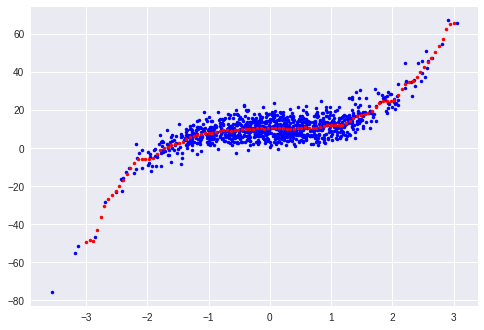

In [97]:
plot_predictions(X, Y, 0.08, 100)

* [Kernel regression estimation](https://bookdown.org/egarpor/NP-UC3M/kre-i-kre.html)
* [Kernel Density Estimation and Non-Parametric Regression](https://towardsdatascience.com/kernel-density-estimation-and-non-parametric-regression-ecebebc75277) 
* [Libreria localreg](https://github.com/sigvaldm/localreg) 
* [tips-locally-weighted-linear-regression](https://www.kaggle.com/alincijov/tips-locally-weighted-linear-regression)
* [Locally weighted linear Regression using Python](https://www.geeksforgeeks.org/locally-weighted-linear-regression-using-python/)*   
* [LOESS Smoothing data using local regression](https://towardsdatascience.com/loess-373d43b03564)
*  [LOWESS Smoother, STATSMODELS](https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html)
*   https://www.allendowney.com/blog/2019/04/01/local-regression-in-python/
*   https://www.geeksforgeeks.org/implementation-of-locally-weighted-linear-regression/
*   https://towardsdatascience.com/locally-weighted-linear-regression-in-python-3d324108efbf

(244, 2)


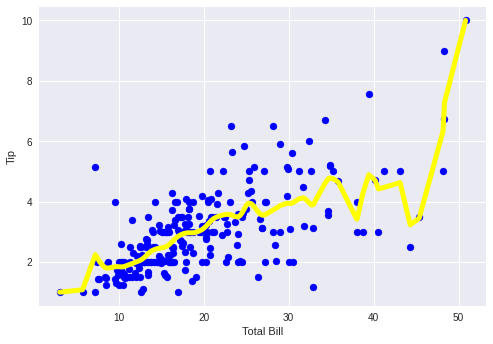

In [98]:
#https://www.codespeedy.com/locally-weighted-linear-regression-in-python/
# kernel smoothing function
def kernel(point, xmat, k):
    m,n = np.shape(xmat)
    weights = np.mat(np.eye((m)))
    
    for j in range(m):
        diff = point - X[j]
        weights[j, j] = np.exp(diff * diff.T / (-2.0 * k**2))
    
    return weights
    
# function to return local weight of eah traiining example
def localWeight(point, xmat, ymat, k):
    wt = kernel(point, xmat, k)
    W = (X.T * (wt*X)).I * (X.T * wt * ymat.T)
    return W

# root function that drives the algorithm
def localWeightRegression(xmat, ymat, k):
    m,n = np.shape(xmat)
    ypred = np.zeros(m)
    
    for i in range(m):
        ypred[i] = xmat[i] * localWeight(xmat[i], xmat, ymat, k)
        
    return ypred

#import data
data = pd.read_csv('tips.csv')

# place them in suitable data types
colA = np.array(data.total_bill)
colB = np.array(data.tip)
mcolA = np.mat(colA)
mcolB = np.mat(colB)
m = np.shape(mcolB)[1]
one = np.ones((1, m), dtype = int)

# horizontal stacking
X = np.hstack((one.T, mcolA.T))
print(X.shape)

# predicting values using LWLR
ypred = localWeightRegression(X, mcolB, 0.8)

# plotting the predicted graph
xsort = X.copy()
xsort.sort(axis=0)
plt.scatter(colA, colB, color='blue')
plt.plot(xsort[:, 1], ypred[X[:, 1].argsort(0)], color='yellow', linewidth=5)
plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.show()

**Conclusión tarea 6** El mejor ajuste de un modelo de regresión local siempre será el de punto por punto, con un modelo por punto.
Puede que el número de intervalos de corte o en este caso puntos query estén definidos.
Puede que además que se incluya el tamaño del vecindario de los intervalos.
En este caso estos son parámetros del modelo, sin embargo si estas son variables de decisión, el modelo se vuelve un problema de optimal binning, y es aplicado a discretización.
En cierto sentido, k es la perilla de sesgo frente a varianza. Los valores grandes de k darán como resultado un mayor sesgo y los valores más bajos inducirán una mayor varianza.


In [99]:
n     = dfdem.shape[0]
exog  = dfdem[['X1']]
endog = dfdem['Y']
kde = KernelReg(endog=endog, exog=exog, var_type='c', bw=[15])

estimator = kde.fit(dfdem['X1'])

estimator = np.reshape(estimator[0],n)
print(type(estimator),type(estimator))
fig, ax   = plt.subplots(figsize=(14,6))
ax.plot( dfdem['Y'], '-',alpha=0.5)
ax.plot( estimator, '-', color='tab:blue', alpha=0.5)
#ax.set_ylim(bottom=10000, top=9500)
plt.show()

NameError: ignored

In [ ]:
df = pd.read_csv('tips.csv')
features = np.array(df.total_bill)
labels = np.array(df.tip)
m = features.shape[0]
mtip = np.mat(labels)
data = np.hstack((np.ones((m, 1)), np.mat(features).T))

In [ ]:
def kernel(data, point, xmat, k):
    m,n = np.shape(xmat)
    ws = np.mat(np.eye((m)))
    
    for j in range(m):
        diff = point - data[j]
        ws[j,j] = np.exp(diff*diff.T/(-2.0*k**2))
    return ws
 
def local_weight(data, point, xmat, ymat, k):
    wei = kernel(data, point, xmat, k)
    return (data.T*(wei*data)).I*(data.T*(wei*ymat.T))
     
def local_weight_regression(xmat, ymat, k):
    m,n = np.shape(xmat)
    ypred = np.zeros(m)
    for i in range(m):
        ypred[i] = xmat[i]*local_weight(xmat, xmat[i],xmat,ymat,k)
    return ypred

In [ ]:
ypred = local_weight_regression(data, mtip, 0.5)
indices = data[:,1].argsort(0)
xsort = data[indices][:,0]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(features, labels, color='green')
ax.plot(xsort[:,1],ypred[indices], color = 'red', linewidth=5)
plt.xlabel('Total bill')
plt.ylabel('Tip')
plt.show();

In [ ]:
# https://gist.github.com/agramfort/850437#
# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)
def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

if __name__ == '__main__':
    import math
    n = 100
    x = np.linspace(0, 2 * math.pi, n)
    y = np.sin(x) + 0.3 * np.random.randn(n)

    f = 0.25
    yest = lowess(x, y, f=f, iter=3)

    import pylab as pl
    pl.clf()
    pl.plot(x, y, label='y noisy')
    pl.plot(x, yest, label='y pred')
    pl.legend()
    pl.show()

In [ ]:
np.random.seed(1234)
x = np.linspace(1.5, 5, 2000)
yf = np.sin(x*x)
y = yf + 0.5*np.random.randn(*x.shape)

y0 = localreg(x, y, degree=0, kernel=rbf.epanechnikov, radius=.1)
y1 = localreg(x, y, degree=1, kernel=rbf.epanechnikov, radius=0.3)
y2 = localreg(x, y, degree=2, kernel=rbf.epanechnikov, radius=0.3)

plt.plot(x, y, '+', markersize=0.6, color='gray')
plt.plot(x, yf, label='Ground truth ($\sin(x^2)$)')
plt.plot(x, y0, label='Moving average')
plt.plot(x, y1, label='Local linear regression')
plt.plot(x, y2, label='Local quadratic regression')
plt.legend()
plt.show()

In [ ]:
N = 50
degree=2

x = np.random.rand(N,2)
y = x[:,0]*x[:,1] + 0.02*np.random.randn(N)
x=X
Y=Y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

m = np.arange(0, 1.05, 0.05)
X, Y = np.meshgrid(m,m)
x0 = np.array([np.ravel(X), np.ravel(Y)]).T
z0 = polyfit(x, y, x0, degree=degree)
Z = z0.reshape(X.shape)

ax.plot_wireframe(X, Y, Z, rcount=10, ccount=10, color='green')
ax.plot3D(x[:,0], x[:,1], y, 'o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
#https://www.geeksforgeeks.org/locally-weighted-linear-regression-using-python/
from ipywidgets import interact
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
%matplotlib inline
output_notebook()
plt.style.use('seaborn-dark')
 
# function to perform locally weighted linear regression
def local_weighted_regression(x0, X, Y, tau):
    # add bias term
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]
     
    # fit model: normal equations with kernel
    xw = X.T * weights_calculate(x0, X, tau)
    theta = np.linalg.pinv(xw @ X) @ xw @ Y
    # "@" is used to
    # predict value
    return x0 @ theta
 
# function to perform weight calculation
def weights_calculate(x0, X, tau):
    return np.exp(np.sum((X - x0) ** 2, axis=1) / (-2 * (tau **2) ))
 
# plot locally weighted regression for different bandwidth values
def plot_lwr(tau):
    # prediction
    domain = np.linspace(-3, 3, num=300)
    prediction = [local_regression(x0, X, Y, tau) for x0 in domain]
 
    plot = figure(plot_width=400, plot_height=400)
    plot.title.text = 'tau=%g' % tau
    plot.scatter(X, Y, alpha=.3)
    plot.line(domain, prediction, line_width=2, color='red')
     
    return plot
 
#define distribution
n = 1000
 
# generate dataset
X = np.linspace(-3, 3, num=n)
Y = np.abs(X ** 3 - 1)
 
# jitter X
X += np.random.normal(scale=.1, size=n)
 
# show the plots for different values of Tau
show(gridplot([
    [plot_lwr(10.), plot_lwr(1.)],
    [plot_lwr(0.1), plot_lwr(0.01)]
]))

In [ ]:
from localreg import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot

N = 500
degree=1

x = np.random.rand(N,2)
y = np.cos(2*np.pi*x[:,0])*(1-x[:,1])
x=X
Y=Y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

m = np.arange(0, 1.05, 0.05)
X, Y = np.meshgrid(m,m)
x0 = np.array([np.ravel(X), np.ravel(Y)]).T
z0 = localreg(x, y, x0, degree=degree, radius=0.2)
Z = z0.reshape(X.shape)

ax.plot_wireframe(X, Y, Z, rcount=10, ccount=10, color='green')
ax.plot3D(x[:,0], x[:,1], y, '.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
R = np.asarray([2,4,5,6,7,8,5,6,3,2,4,7,3,4,2,4,6,8,5,3,45,6,8,9,6,4,6,8,3,4,3,1,2,5,9,8,4,7,6,5,3,2,5,7,3,5,3,2,4,5,2,6,7,5,5])
import numpy as np
rng = np.random.RandomState(42)
R = rng.random_sample((100, 3))
kdeGauss = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(R)
log_density = kdeGauss.score_samples(R[:3])

kdeEspane = KernelDensity(kernel='epanechnikov', bandwidth=0.05).fit(R)


In [ ]:
# kernel smoothing function
def kernel(point, xmat, k):
    m,n = np.shape(xmat)
    weights = np.mat(np.eye((m)))
    
    for j in range(m):
        diff = point - X[j]
        weights[j, j] = np.exp(diff * diff.T / (-2.0 * k**2))
    
    return weights